This notebook describes part of the PeeringDB dataset.  
It consists in IXP metadata (table `ix`), ASes metadata (table `net`), a directed Graph (`DiGraph`) and a table containing the graph's nodes metadata (table `nodes`).

In [198]:
import numpy as np
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt

# Loading preprocessed data
Notes on the preprocessing: 
* All entries are uniquely defined with an index.
 * ASes: the index is the AS number (asn)
 * IXPs: a negative number that I attributed
* The graph is first built from infos present in `netixlan_set` of the API. This makes a bipartite graph (AS-IXP) with links weighted by the router port size (`speed` in the API)
* We want to derive a directed graph: we rely on ASes `info_ratio` attribute, that can take the values `Not Disclosed`, `Heavy In(out)bound`, `Mostly In(out)bound`, `Balanced`.
 * Inbound: a link is created with a weight=`speed` from IXP to AS. Another link of weight $(1-\beta)$*`speed` is created in the other direction
 * Outbound: a link is created with a weight=`speed` from AS to IXP. Another link of weight $(1-\beta)$*`speed` is created in the other direction
 * `Balanced` or `Not Disclosed`: A link in both direction with a weight=`speed`
 * Heavy categories: $\beta=\beta_H=0.95$, Mostly categories: $\beta=\beta_M=0.75$

In [199]:
path = "./"
prefix = "peeringdb_2_dump_"
date = "2021_03_01"

pickle_in = open(path+"nodes/"+prefix+date+".pickle", "rb")
nodes = pickle.load(pickle_in)
pickle_in.close()
nodes = nodes.loc[nodes["port_capacity"]>0] ##port capacity = sum of all ports
print("nodes table summary")
display(nodes.info())

pickle_in = open(path+"ix/"+prefix+date+".pickle", "rb")
ix = pickle.load(pickle_in)
pickle_in.close()
ix = ix.loc[ix["port_capacity"]>0]
print("ix table summary")
display(ix.info())

pickle_in = open(path+"net/"+prefix+date+".pickle", "rb")
net = pickle.load(pickle_in)
pickle_in.close()
net = net.loc[net["port_capacity"]>0]
print("net table summary")
display(net.info())

BETA_H = 0.95
BETA_M = 0.75

edgelist = open(path+"graph/"+format(BETA_H, '.4f')+"_"+format(BETA_M, '.4f')+"_"+prefix+date+".txt", "r")
DiGraph = nx.parse_edgelist(edgelist, nodetype = int, data=(('weight',float),), create_using = nx.DiGraph, delimiter=",")


assert(len(nodes) == len(ix) + len(net))
assert(len(nodes) == len(DiGraph))

print("Total number of nodes:", len(nodes))
print("Total number of IXP:", len(ix))
print("Total number of ASes: ", len(net))
print("Total number of edges: ", len(DiGraph.edges()))

nodes table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12282 entries, 20940 to -893
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           12282 non-null  object 
 1   type           12282 non-null  object 
 2   prev_id        12282 non-null  int64  
 3   AStype         11472 non-null  object 
 4   region         12282 non-null  object 
 5   asn            12282 non-null  int64  
 6   port_capacity  12282 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 767.6+ KB


None

ix table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 810 entries, -1 to -893
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   proto_ipv6        810 non-null    bool  
 1   status            810 non-null    object
 2   url_stats         810 non-null    object
 3   id                810 non-null    int64 
 4   tech_email        810 non-null    object
 5   city              810 non-null    object
 6   policy_email      810 non-null    object
 7   tech_phone        810 non-null    object
 8   media             810 non-null    object
 9   proto_multicast   810 non-null    bool  
 10  ixf_last_import   127 non-null    object
 11  website           810 non-null    object
 12  updated           810 non-null    object
 13  net_count         810 non-null    int64 
 14  policy_phone      810 non-null    object
 15  proto_unicast     810 non-null    bool  
 16  region_continent  810 non-null    object
 1

None

net table summary
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11472 entries, 20940 to 61437
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   status                        11472 non-null  object 
 1   looking_glass                 11472 non-null  object 
 2   route_server                  11472 non-null  object 
 3   netixlan_updated              11472 non-null  object 
 4   info_ratio                    11472 non-null  object 
 5   id                            11472 non-null  int64  
 6   policy_ratio                  11472 non-null  bool   
 7   info_unicast                  11472 non-null  bool   
 8   policy_general                11472 non-null  object 
 9   website                       11472 non-null  object 
 10  allow_ixp_update              11472 non-null  bool   
 11  updated                       11472 non-null  object 
 12  netfac_updated                7121 non

None

Total number of nodes: 12282
Total number of IXP: 810
Total number of ASes:  11472
Total number of edges:  63914


# Selecting the main connected component
Most graph algorithms behave best when the graph has a single connected component 

In [200]:
##I work only with the main connected component. Some entries of nodes, ix and net must be removed
##Main connected component.
#watch out casting DiGraph to Graph is not correct (delete doubled edges). For our use here it will be fine.
components = sorted(nx.connected_components(nx.Graph(DiGraph)), key=len, reverse=True) 
print("Number of connected components", len(components))
print("Percentage of nodes in the graph main connected component", 100.0*len(components[0])/DiGraph.number_of_nodes())
DiGraph = DiGraph.subgraph(components[0])

##Removing entries.
for i in range(1,len(components)):
    component = components[i]
    for node in component:
        #if node is an AS
        if node >= 0:
            net.drop(index=node, inplace=True)
            nodes.drop(index=node, inplace=True)
        #if node is an IXP
        if node < 0:
            ix.drop(index=node, inplace=True)
            nodes.drop(index=node, inplace=True)
            
assert(len(nodes) == len(ix) + len(net))
assert(len(nodes) == len(DiGraph))

Number of connected components 28
Percentage of nodes in the graph main connected component 99.22651034033545


- #### Définition des colonnes pertinentes pour l'étude

In [205]:
list_columns_ix = ['net_count', 'name', 'country', 
                   'notes', 'port_capacity', 'asn', 'ixf_net_count', 'id']

list_columns_net = ['info_ratio', 'id', 'policy_general', 'policy_locations',
                    'info_traffic', 'asn', 'info_type', 'ix_count', 'port_capacity']

- L'IXP n° -212 n'est relié qu'à 2 AS (net_count = 2)
- L'AS n° 20144 est principalement sortant (poids élevé en sortie d'AS vers ses IXP membres)

In [206]:
ix[list_columns_ix] [ix['asn'] == -212]

,net_count,name,country,notes,port_capacity,asn,ixf_net_count,id
asn,,,,,,,,
-212,2,GigaPIX - Oporto,PT,,3000,-212,0,368


In [207]:
net[list_columns_net] [net['asn'] == 20144]

,info_ratio,id,policy_general,policy_locations,info_traffic,asn,info_type,ix_count,port_capacity
asn,,,,,,,,,
20144,Mostly Outbound,618,Selective,Not Required,1-5Gbps,20144,Non-Profit,22,58000.0


In [208]:
# Afficher quelques AS nodes et IXP nodes
nodes[nodes.asn<50].head()

,name,type,prev_id,AStype,region,asn,port_capacity
asn,,,,,,,
42,Packet Clearing House AS42,AS,3924,Educational/Research,Global,42,559507.0
46,Rutgers University,AS,9329,Educational/Research,Regional,46,100000.0
-1,Equinix Ashburn,IXP,1,NaN,North America,-1,14120580.0
-2,Equinix Chicago,IXP,2,NaN,North America,-2,11511604.0
-3,Equinix Dallas,IXP,3,NaN,North America,-3,8022300.0


In [209]:
net[['info_traffic', 'port_capacity']].head()

,info_traffic,port_capacity
asn,,
20940,100+Tbps,23992000.0
31800,100-1000Mbps,6800.0
22822,1-5Tbps,7331000.0
3303,1-5Tbps,407700.0
6079,1-5Tbps,370000.0


## PEERINGDB

doc attributs peeringDB : https://www.peeringdb.com/apidocs/#operation/list%20net

## ROUTE SERVER 
- Les serveurs de routes, aussi connus sous le nom de RS (route servers) permettent aux membres de réduire le nombre de sessions BGP à configurer et donc le temps de gestion de son réseau IP. En effet, par défaut toutes les routes des membres connectés aux RS sont redistribuées.


- Un serveur de routes n’est pas un routeur, le flux de données est directement échangé entre les participants, seules les informations BGP sont échangées avec le RS. Par exemple, si deux membres établissent une session BGP avec les RS, seules les informations de routages seront échangées par les Route-Serveurs (Control-plane), le flux de donnée sera direct entre leur routeur (Data-plane) car ils sont dans le même LAN.

 

| Attribute name        | Meaning           | Possible values  |
| :-------------:       |:---------------:  | :--------------: |
| **info_type**     | classification de l'AS (NaN pour un IXP) | `Cable/DSL/ISP` `NSP` `Content` `Not Disclosed` `Enterprise` `Educational/Research` `Non-Profit` `Route Server` `""` `Network Services` `Route Collector` `Government`
| **info_ratio** | politique de communication de l'AS | `"" ` `Not Disclosed` `Heavy Outbound` <br><br>`Mostly Outbound` `Balanced` `Mostly Inbound` `Heavy Inbound` 
| **info_scope** | origine géographique de la mesure | `Not Disclosed` `Regional` `North America` <br>`Asia Pacific` `Europe` `South America` `Africa` `Australia` `Middle East` `Global` 
| **policy_general** |politique de traffic de l'AS | `Open` `Selective` `Restrictive` `No`| 
| **info_traffic** | ordre de grandeur du traffic | `""` `0-20Mbps` `20-100Mbps` `100-1000Mbps`  `1-5Gbps` `5-10Gbps` `10-20Gbps` `20-50Gbps` `50-100Gbps` `100-200Gbps` `200-300Gbps` `300-500Gbps` `500-1000Gbps` `1-5Tbps` `5-10Tbps` `10-20Tbps` `20-50Tbps` `50-100Tbps` `100+Tbps`
| **id**  | id de l'ixp | Integer
| **media**  | type de transfert de données | `Ethernet` `ATM` `Multiple`
| proto_multicast | protocol multicast used | `True` `False`
|region_continent | continent de l'ixp |`North America` `Asia Pacific` `Europe` `South America` `Africa` `Australia` `Middle Eastregion_continent`
|port_capacity | bande passante d'un port | value in gigabyte 
| ix_count( pour les AS) | nombre d'échanges sur ce réseau | `integer <int64> [ 0 .. 4294967295 ]`
| info_prefixes4 | Recommended maximum number of IPv4 routes/prefixes to be configured on peering sessions for this ASN| Integer

In [215]:
net[list_columns_net].sort_values(by='ix_count', ascending=False)

,info_ratio,id,policy_general,policy_locations,info_traffic,asn,info_type,ix_count,port_capacity
asn,,,,,,,,,
15169,Mostly Outbound,433,Open,Preferred,,15169,Content,328,19590000.0
32934,Heavy Outbound,979,Selective,Not Required,100+Tbps,32934,Content,314,26860000.0
8075,Mostly Outbound,694,Selective,Preferred,,8075,Content,282,18730000.0
6939,Balanced,291,Open,Preferred,20-50Tbps,6939,NSP,262,10484000.0
13335,Mostly Outbound,4224,Open,Preferred,,13335,Content,249,11310000.0
...,...,...,...,...,...,...,...,...,...
328043,Balanced,16342,Open,Not Required,20-100Mbps,328043,Enterprise,1,1000.0
27660,Mostly Inbound,16341,Selective,Not Required,,27660,Cable/DSL/ISP,1,10000.0
36445,Heavy Inbound,7969,Open,Not Required,1-5Gbps,36445,Cable/DSL/ISP,1,10000.0


In [211]:
net['policy_locations'].value_counts()

Not Required                9962
Preferred                   1218
Required - International      88
                              71
Required - US                 36
Required - EU                 32
Name: policy_locations, dtype: int64

In [220]:
net[list_columns_net] [net['policy_locations'] == 'Required - International'].sort_values(by='port_capacity', ascending=False)

,info_ratio,id,policy_general,policy_locations,info_traffic,asn,info_type,ix_count,port_capacity
asn,,,,,,,,,
3356,Balanced,504,Restrictive,Required - International,100+Tbps,3356,NSP,9,1740000.0
6461,Balanced,541,Restrictive,Required - International,10-20Tbps,6461,NSP,47,1642000.0
2497,Balanced,690,Restrictive,Required - International,,2497,NSP,22,1420000.0
8220,Balanced,91,Selective,Required - International,1-5Tbps,8220,NSP,43,1080000.0
7713,Heavy Inbound,2803,Restrictive,Required - International,10-20Tbps,7713,NSP,42,1035000.0
...,...,...,...,...,...,...,...,...,...
36052,Balanced,3451,Open,Required - International,100-1000Mbps,36052,NSP,1,1000.0
17579,Balanced,2208,Open,Required - International,1-5Gbps,17579,Educational/Research,1,1000.0
209309,Balanced,25392,Open,Required - International,50-100Gbps,209309,Not Disclosed,1,1000.0


(array([23.,  4.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.]),
 array([1.0000e+02, 3.4090e+04, 6.8080e+04, 1.0207e+05, 1.3606e+05,
        1.7005e+05, 2.0404e+05, 2.3803e+05, 2.7202e+05, 3.0601e+05,
        3.4000e+05]),
 <BarContainer object of 10 artists>)

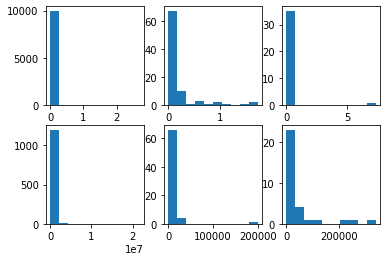

In [244]:
plt.subplot(2,3,1)
plt.hist(net['port_capacity'] [net['policy_locations'] == 'Not Required'])
plt.subplot(2,3,4)
plt.hist(net['port_capacity'] [net['policy_locations'] == 'Preferred'])
plt.subplot(2,3,2)
plt.hist(net['port_capacity'] [net['policy_locations'] == 'Required - International'])
plt.subplot(2,3,5)
plt.hist(net['port_capacity'] [net['policy_locations'] == ''])
plt.subplot(2,3,3)
plt.hist(net['port_capacity'] [net['policy_locations'] == 'Required - US'])
plt.subplot(2,3,6)
plt.hist(net['port_capacity'] [net['policy_locations'] == 'Required - EU'])

In [246]:
net['netixlan_set'].head(1)

asn
20940    [{'ix_id': 1, 'operational': True, 'asn': 2094...
Name: netixlan_set, dtype: object

In [35]:
nodes['AStype'].value_counts() 

Cable/DSL/ISP           4993
NSP                     2135
Content                 1226
Not Disclosed           1179
Enterprise               625
Educational/Research     500
Non-Profit               320
Route Server             258
                         122
Network Services          27
Route Collector           12
Government                10
Name: AStype, dtype: int64

In [38]:
net['info_traffic'].value_counts()

                3112
1-5Gbps         2093
5-10Gbps        1263
100-1000Mbps    1149
10-20Gbps       1055
20-50Gbps        900
50-100Gbps       555
100-200Gbps      313
20-100Mbps       231
1-5Tbps          178
0-20Mbps         149
500-1000Gbps     130
300-500Gbps      123
200-300Gbps      117
10-20Tbps         17
5-10Tbps          13
20-50Tbps          5
100+Tbps           3
50-100Tbps         1
Name: info_traffic, dtype: int64

In [150]:
net['port_capacity'].sort_values(ascending=False).head(100)

asn
32934     26860000.0
20940     23992000.0
16509     21640000.0
15169     19590000.0
8075      18730000.0
             ...    
16735       921000.0
9049        921000.0
13238       893000.0
2635        890000.0
263237      890000.0
Name: port_capacity, Length: 100, dtype: float64

In [151]:
ix[['net_count', 'port_capacity']].sort_values(by='port_capacity', ascending=False).head(650)

,net_count,port_capacity
asn,,
-102,1309,50251588
-24,924,45180600
-21,857,39243675
-15,787,24737596
-98,341,18934200
...,...,...
-320,4,13000
-225,5,13000
-724,13,13000


In [63]:
nodes['port_capacity'].sort_values(ascending=False).head(500)

asn
-102      50251588.0
-24       45180600.0
-21       39243675.0
 32934    26860000.0
-15       24737596.0
             ...    
 46618       20000.0
 59842       20000.0
 19116       20000.0
 53085       20000.0
 46811       20000.0
Name: port_capacity, Length: 5000, dtype: float64

In [184]:
net['policy_general'].value_counts()

Open           9217
Selective      1921
Restrictive     167
                 71
No               31
Name: policy_general, dtype: int64

In [58]:
DiGraph[-212]

AtlasView(FilterAtlas({20144: {'weight': 500.0}, 1930: {'weight': 1000.0}}, <function FilterAdjacency.__getitem__.<locals>.new_node_ok at 0x000001E154B42430>))

- ### Ajout de la colonne `port_capacity_scaled`

In [13]:
max_portAS = max(nodes['port_capacity']) # maximum value of port_capacity among ixp & nodes
port_capacity = nodes['port_capacity']


nodes['port_capacity_scaled'] = port_capacity/max_portAS

In [14]:
nodes[['port_capacity', 'port_capacity_scaled']].sort_values(by='port_capacity_scaled', ascending=False).head(10)

,port_capacity,port_capacity_scaled
asn,,
-102,50251588.0,1.000000
-24,45180600.0,0.899088
-21,39243675.0,0.780944
32934,26860000.0,0.534510
-15,24737596.0,0.492275
20940,23992000.0,0.477438
16509,21640000.0,0.430633
15169,19590000.0,0.389838
-98,18934200.0,0.376788


In [148]:
DiGraph[20144]

AtlasView(FilterAtlas({-48: {'weight': 10000.0}, -98: {'weight': 10000.0}, -102: {'weight': 10000.0}, -104: {'weight': 1000.0}, -105: {'weight': 1000.0}, -106: {'weight': 1000.0}, -107: {'weight': 1000.0}, -108: {'weight': 1000.0}, -109: {'weight': 1000.0}, -123: {'weight': 10000.0}, -153: {'weight': 1000.0}, -155: {'weight': 1000.0}, -182: {'weight': 1000.0}, -212: {'weight': 2000.0}, -229: {'weight': 1000.0}, -232: {'weight': 1000.0}, -265: {'weight': 1000.0}, -297: {'weight': 1000.0}, -314: {'weight': 1000.0}, -316: {'weight': 1000.0}, -317: {'weight': 1000.0}}, <function FilterAdjacency.__getitem__.<locals>.new_node_ok at 0x000001E154F0C9D0>))

 Calcul des *page_rank*

In [4]:
pagerank_pondere = nx.pagerank(DiGraph)
pagerank = nx.pagerank(DiGraph, weight=None)
pagerank_pondere_inverse = nx.pagerank(DiGraph.reverse(copy=True))
pagerank_inverse = nx.pagerank(DiGraph.reverse(copy=True), weight=None)